Parameters:
     a 16.8
     b 3.32e-05
 alpha 5.05
 theta 1.27


<Axes: xlabel='Date'>

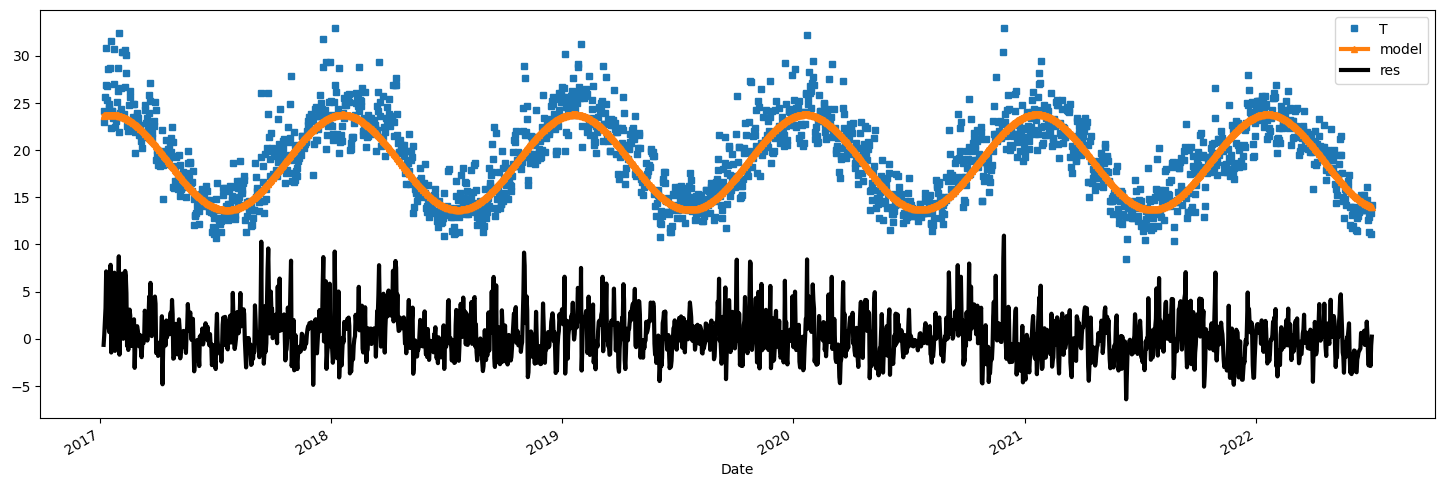

In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


dir_path = os.path.dirname(os.path.realpath('__file__'))
data_folder = os.path.join(dir_path, 'statistical analysis')
max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')

def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

temps = max_temp.merge(min_temp, how='inner', left_on=['Date'], right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp, axis=1)

# drop na values here 
temps = temps.dropna()

temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

def model(x, params): 
    a,b,a1,b1 = params 
    omega = 2*np.pi/365.25
    theta = np.arctan(a1/b1)
    alpha = np.sqrt(a1**2 + b1**2)
    print('Parameters:\n     a {0:0.3}\n     b {1:0.3}\n alpha {2:0.3}\n theta {3:0.3}'.format(a,b,alpha,theta))
    y_pred = a + b*x + alpha*np.sin(omega*x + theta)
    return y_pred

def model_fit(x, a, b, a1, b1):
    omega = 2*np.pi/365.25
    y_pred = a + b*x + a1*np.cos(omega*x) + b1*np.sin(omega*x)
    return y_pred

if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)

params_all, cov = curve_fit(model_fit, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method='lm')

temp_t['model'] = model(temp_t.index-first_ord, params_all)
temp_t['res'] = temp_t['T']-temp_t['model']


if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)

temp_t[-2000:].plot(figsize=(18,6), style=['s','^-','k-'] , markersize=4, linewidth=3 )

## Why not a mean-reverting Orstein-Uhlenbeck (OU) process? 

$$dT_{t} = \kappa(\bar{T}_{t} - T_{t})dt + \sigma_{t}dW_{t} $$

, where $ \mathbb{E}[T_{t}] \approx \bar{T}_{t} $

## Using Îto-Doeblin formula 

Îto-Doeblin formula for a stochastic process $X$: 
$$df(t,x) = f_{t}(t,x)dt + f_{x}(t,x)dx + \frac{1}{2}f_{xx}(t,x)dxdx$$

Choosing Cox-Ingresoll-Ross (CIR) interest rate model for $f(t,x)$: 
$$f(t,x) = e^{t\kappa}x$$

## Solving for SDE
Applying Îto-Doeblin to an SDE with T_{t} as the Îto process: 

$$
d(e^{\kappa t} T_t) = df(t, T_t) = f_t(t, T_t) dt + f_x(t, T_t) dT_t + \frac{1}{2} f_{xx}(t, T_t) dT_t dT_t
$$

$$
d(e^{\kappa t} T_t) = \kappa e^{\kappa t} T_t dt + e^{\kappa t} dT_t + \frac{1}{2} (0) dT_t dT_t \quad \text{(here we can substitute in dynamics \(dT_t\))}
$$

$$
d(e^{\kappa t} T_t) = \kappa e^{\kappa t} T_t dt + e^{\kappa t} \kappa (\bar{T}_t - T_t) dt + e^{\kappa t} \sigma_t dW_t \quad \text{(cross out canceling terms of \(\kappa e^{\kappa t} T_t dt\))}
$$

$$
d(e^{\kappa t} T_t) = \kappa e^{\kappa t} \bar{T}_t dt + e^{\kappa t} \sigma_t dW_t \quad \text{(take the integral over interval \(u \in [s, t], t > s\))}
$$

$$
\int_s^t d(e^{\kappa u} T_u) = e^{\kappa t} T_t - e^{\kappa s} T_s = \int_s^t \kappa e^{\kappa u} \bar{T}_u du + \int_s^t e^{\kappa u} \sigma_u dW_u
$$

$$
e^{\kappa t} T_t = e^{\kappa s} T_s + \int_s^t \kappa e^{\kappa u} \bar{T}_u du + \int_s^t e^{\kappa u} \sigma_u dW_u \quad \text{(change base on Riemann integral to \(d\bar{T}_t\))}
$$

$$
e^{\kappa t} T_t = e^{\kappa s} T_s + \int_s^t e^{\kappa u} d\bar{T}_u + \int_s^t e^{\kappa u} \sigma_u dW_u \quad \text{(divide through LHS by \(e^{\kappa t}\) factor)}
$$

$$
T_t = T_s e^{-\kappa (t-s)} + \int_s^t e^{-\kappa (t-u)} d\bar{T}_u + \int_s^t e^{-\kappa (t-s)} \sigma_t dW_u
$$

$$
T_t = T_s e^{-\kappa (t-s)} + \bar{T}_t e^{-\kappa (t-t)} - \bar{T}_s e^{-\kappa (t-s)} + \int_s^t e^{-\kappa (t-s)} \sigma_t dW_u \quad \text{(group terms)}
$$

$$
T_t = \bar{T}_t + (T_s - \bar{T}_s) e^{-\kappa (t-s)} + \int_s^t e^{-\kappa (t-s)} \sigma_t dW_u
$$

$$
\therefore \mathbb{E}[T_{t}] = \bar{T}_{t} + (T_{s} - \bar{T}_{s})e^{-\kappa(t-2)} \ne \bar{T}_{t}
$$

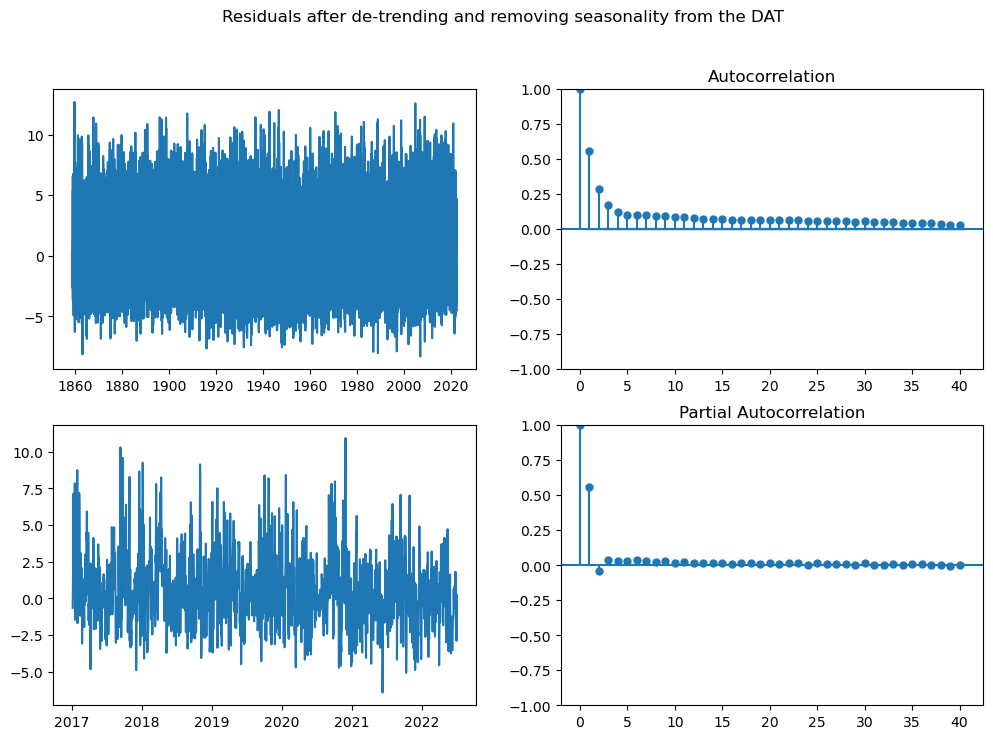

In [3]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()


$$
dT_t = \left[d\bar{T}_t + \kappa(\bar{T}_t - T_t)dt\right] + \sigma_t dW_t
$$

Using the integrating factor $e^{\int_0^t \kappa du}$, the left-hand side becomes the differential of a product:

$$
e^{\int_0^t \kappa du} d\bar{T}_u - e^{\int_0^t \kappa du} \kappa (\bar{T}_u - T_u) du + e^{\int_0^t \kappa du} dT_u = e^{\int_0^t \kappa du} \sigma_t dW_u
$$

$$
\implies d\left[e^{\int_0^t \kappa du} (\bar{T}_u - T_u)\right] = e^{\int_0^t \kappa du} \sigma_t dW_u
$$

Let $Z_t = e^{\int_0^t \kappa du} (\bar{T}_u - T_u)$. Then, its dynamics are:

$$
dZ_t = e^{\int_0^t \kappa du} \sigma_t dW_u
$$

$$
\implies Z_t = Z_0 - \int_0^t e^{\int_0^t \kappa du} \sigma_t dW_u
$$

Substituting $Z_t = e^{\int_0^t \kappa du} (\bar{T}_u - T_u)$ into the equation:

$$
e^{\int_0^t \kappa du} (\bar{T}_t - T_t) = e^{\int_0^t \kappa du} (\bar{T}_0 - T_0) - \int_0^t e^{\int_0^t \kappa du} \sigma_t dW_u
$$

Finally, solving for $T_t$:

$$
T_t = \bar{T}_t + e^{-\int_0^t \kappa du} \int_0^t e^{\int_0^t \kappa du} \sigma_t dW_u
$$

The expectation is:

$$
\mathbb{E}[T_t] = \bar{T}_t
$$


## Modified OU Dynamics

Expectation of the following stochastic process == longrun average over dynamic Monthly Average Temperature (MAT):
$$ dT_{t} = \left[\frac{d\bar{T}_{t}}{dt} + 0.438 (\bar{T}_{t} - t_{t})\right] dt + \sigma_{t}dW_{t} $$

, where DAT $T_{t}$ is described as follows: 

$$ \bar{T}_{t} = 16.8 + (3.32e - 05)t + 5.05\sin\left(\left(\frac{2\pi}{365.25}\right)t + 1.27\right)$$

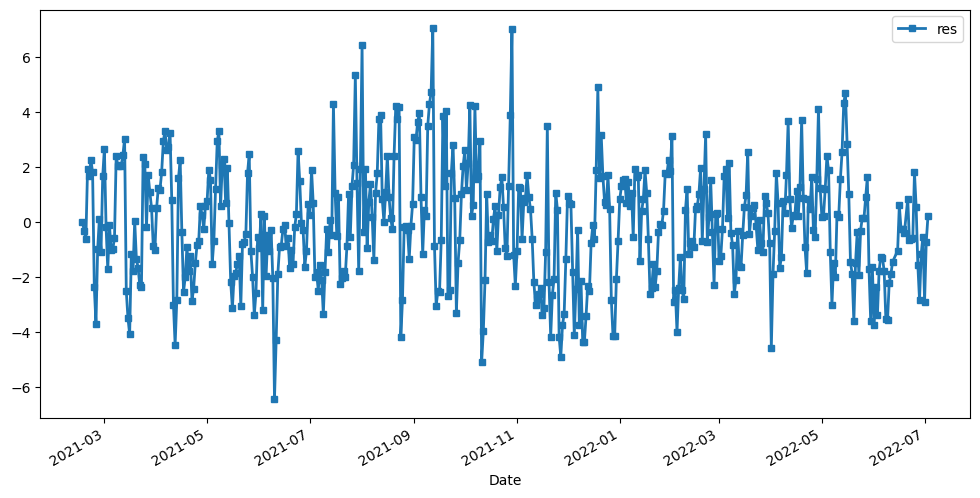

In [4]:
temp_t[['res']][-500:].plot(figsize=(12,6), style=['s-'] , markersize=4, linewidth=2 )
plt.show()

## Estimating Speed of Mean Reversion 

$$ dT_{t} = \left[\frac{d\bar{T}_{t}}{dt} + \kappa(\bar{T}_{t} - T_{t})\right] dt + \sigma_{t}dW_{t} \text{, where } t\in[i-1,i]$$ 

$$\implies T_{i} - T_{i-1} = \bar{T}_{i} - \bar{T}_{i-1} + \kappa(\bar{T}_{i-1} - T_{i-1}) + \sigma_{i}z_{i}$$

$$\implies T_{i} - \bar{T}_{i} = T_{i-1} + \bar{T}_{i-1} - \kappa(T_{i-1}\bar{T}_{i-1}) + \sigma_{i}z_{i}$$

, where $z_{t} ~ N(0,1)$. 

Defining the transformation $\hat{T}_{t} = T_{t} - \bar{T}_{t}$, we get the following: 

$$ \hat{T}_{i} = \hat{T}_{i-1} - \kappa(\hat{T}_{i-1}) + \sigma_{i}z_{i} $$

$\hat{T}_{i}$ can be modelled as an AR(1) process: 

$$\hat{T}_{i} = \gamma \hat{T}_{i-1} + e_{i}$$

, where $\kappa = 1 - \gamma$ and $e_{i} = \sigma_{i}z_{t}$. 

## Fitting an Autoregressive Model with 1 lag 

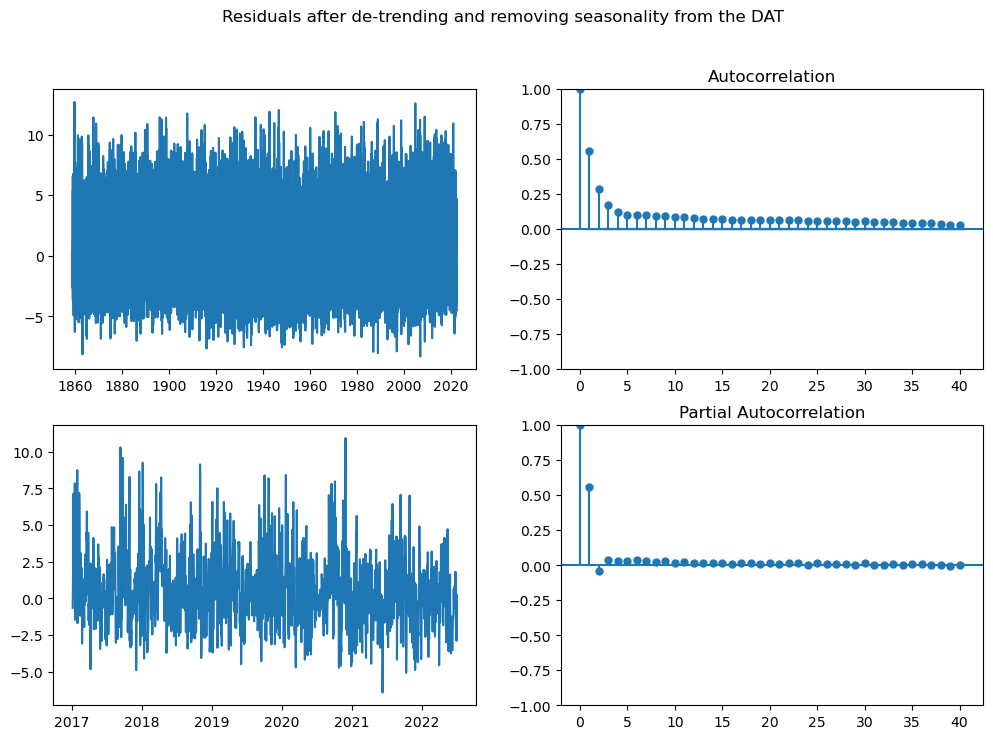

In [5]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality from the DAT')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])
plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

In [6]:
residuals = temp_t['res']
residuals.index = pd.DatetimeIndex(residuals.index).to_period('D')

model = AutoReg(residuals, lags=1, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
# res.index = res.index.to_timestamp()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                    res   No. Observations:                59557
Model:                     AutoReg(1)   Log Likelihood             -123373.258
Method:               Conditional MLE   S.D. of innovations              1.921
Date:                Fri, 27 Dec 2024   AIC                         246750.516
Time:                        23:08:11   BIC                         246768.506
Sample:                    01-02-1859   HQIC                        246756.106
                         - 07-03-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res.L1         0.5617      0.003    165.700      0.000       0.555       0.568
                                    Roots                                    
                  Real          Imaginary           M

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_56005/1549097711.py:4: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  model = AutoReg(residuals, lags=1, old_names=True,trend='n')


In [7]:
gamma = coef[0]
kappa = 1 - gamma

print("Kappa is estimated as: {:0.3}".format(kappa))

Kappa is estimated as: 0.438


/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_56005/4281442739.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = coef[0]


## Particular Modified OU Dynamics 

$$ dT_{t} = \left[\frac{d\bar{T}_{t}}{dt} + 0.438 (\bar{T}_{t} - t_{t})\right] dt + \sigma_{t}dW_{t} $$

, where DAT $T_{t}$ and its first derivative are described as follows: 

$$ \bar{T}_{t} = 16.8 + (3.32e - 05)t + 5.05\sin\left(\left(\frac{2\pi}{365.25}\right)t + 1.27\right)$$

$$ \bar{T'}_{t} = (3.32e - 05) + 5.05\left(\frac{2\pi}{365.25}\right)\cos\left(\left(\frac{2\pi}{365.25}\right)t + 1.27\right)$$